# Try to classify contigs as prokaryotic or eukaryotic just from an alignment

General idea: eukaryotic contigs, compared with prokaryotic contigs, should have relatively high amounts of positions with mutation frequencies around 50% (representing diploidy).

In [98]:
%run "Header.ipynb"
%run "../../prok-euk/params.py"
%run "../../prok-euk/gmf.py"
import os
import math
import json
import skbio
import pysam
import pysamstats
from statistics import mean

In [3]:
PE_OUT_DIR = "../../prok-euk/output/"

## Load data: sheep gut contigs

This is obviously a very _ad hoc_ way of defining a file format. If this ever becomes a tool people use, it'd be a lot faster / more efficient to store this in a dedicated table structure!

These JSONs should already be filtered to edges with sufficient length and average coverage.

In [24]:
with open(os.path.join(PE_OUT_DIR, "frac-info.txt"), "r") as pef:
    for linenum, line in enumerate(pef, 1):
        if linenum == 1:
            edge2num_wc_pos = json.loads(line.strip())
            print(f"{len(edge2num_wc_pos):,} edges in edge2num_wc_pos.")
        elif linenum == 2:
            edge2num_wc_diploid_pos = json.loads(line.strip())
            print(f"{len(edge2num_wc_diploid_pos):,} edges in edge2num_wc_diploid_pos.")
        elif linenum == 3:
            edge2num_wc_den_pos = json.loads(line.strip())
            print(f"{len(edge2num_wc_den_pos):,} edges in edge2num_wc_den_pos.")

12,107 edges in edge2num_wc_pos.
12,107 edges in edge2num_wc_diploid_pos.
12,107 edges in edge2num_wc_den_pos.


In [25]:
with open(os.path.join(PE_OUT_DIR, "edge2meancov.json"), "r") as emcf:
    edge2meancov = json.load(emcf)
print(f"{len(edge2meancov):,} edges in edge2meancov.")

43,562 edges in edge2meancov.


In [26]:
with open(os.path.join(PE_OUT_DIR, "edge2len.json"), "r") as elf:
    edge2len = json.load(elf)
long_enough_seqs = [e for e in edge2len if edge2len[e] >= MIN_SEQ_LEN]
print(f"{len(long_enough_seqs):,} edges with sufficient length.")

43,562 edges with sufficient length.


## Load data: contig from a human genome assembly

In [34]:
# NOTE: This is a huge file, if this needs to be adapted into a pipeline or something this should be modified
# so that the file is read line-by-line or something rather than all at once
with open(os.path.join(PE_OUT_DIR, "h1tg000001l-mincov-pos-mutation-rates.json"), "r") as hf:
    h_mut_rates = json.load(hf)["h1tg000001l"]
    
print(f"There are {len(h_mut_rates):,} positions described in this file.")

There are 87,940,234 positions described in this file.


In [35]:
num_wc_pos = len(h_mut_rates)
# the 2e6 accounts for the positions we sliced off
num_total_pos = len(skbio.DNA.read(os.path.join(PE_OUT_DIR, "h1tg000001l.fasta"))) - int(2e6)
human_wc_frac = num_wc_pos / num_total_pos
print(f"Human contig region has {num_wc_pos:,} WC pos, and {num_total_pos:,} total pos.")
print(f"Therefore, fraction of WC pos to total pos is {human_wc_frac * 100:.2f}%.")

Human contig region has 87,940,234 WC pos, and 99,329,166 total pos.
Therefore, fraction of WC pos to total pos is 88.53%.


## Utility functions for showing histograms

`fracplot` is useful for showing histograms of edge "fractions" of some sort, where each edge has an associated fraction.

`seq_mutrate_hist` is useful for showing histograms of positions' mutation rates.

In [68]:
def fracplot(
    edge2frac,
    numerator_desc,
    denominator_desc,
    denclause="\nand a nonzero denominator",
    xlabel="Fraction of 'diploid' positions (%)",
    use_symlog=True,
    bar_interior_color="#660066",
    bar_exterior_color="#220022",
    vlines=[],
    figfilename=None
):
    """Utility function to make it easy to draw these histograms of fractions.
    
    A lot of the code here is yanked from the diversity index notebook I wrote.
    """
    fig, ax = pyplot.subplots(1)
    num_edges = len(edge2frac)
    print(f"{num_edges:,} edges represented in this edge2frac object.")
    fracs = [100 * v for v in edge2frac.values()]
    
    # For reference, print info about extreme edge values, for help with sanity-checking
    # The key=edge2frac.get thing lets us essentially just do argmax: https://stackoverflow.com/a/280156
    sorted_edges = sorted(edge2frac.keys(), key=edge2frac.get)
    max_edge = sorted_edges[-1]
    min_edge = sorted_edges[0]
    print(f"Max frac: {max(fracs)} (edge {max_edge}); min frac: {min(fracs)} (edge {min_edge})")
    N = 10
    print(f"Top {N} edges: {sorted_edges[-N:]}")
    print(f"Bottom {N} edges: {sorted_edges[:N]}")
    
    # Possible to allow this to be reduced, but currently we only need 100% max here
    #xlim_max = math.ceil(max(fracs))
    xlim_max = 100
    bins = range(xlim_max + 1)
    ax.hist(
        fracs, 
        color=bar_interior_color,
        linewidth=1,
        edgecolor=bar_exterior_color,
        bins=bins
    )
    if xlim_max < 20:
        ax.set_xticks(bins)
    else:
        ax.set_xticks(range(0, xlim_max + 1, 10))
    if use_symlog:
        ax.set_yscale("symlog")
        
    ax.set_xlim(0, xlim_max)
    
    for vline_info in vlines:
        ax.axvline(vline_info[0] * 100, label=vline_info[1], color="#ee0000", linestyle=":")
        
    if len(vlines) > 0:
        ax.legend()
        
    # Don't write the axis numbers as 10^0, 10^1, etc. -- just write as 1, 10, etc.
    # https://stackoverflow.com/a/49751075
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

    use_thousands_sep(ax.yaxis)

    ax.set_ylabel("Number of contigs with fractions in a range")
    ax.set_xlabel(xlabel)
    ax.set_title(
        f"Histogram of {num_edges:,} sheep gut contigs with length $\geq$ 5,000{denclause}:\n" +
        r"$\frac{\mathrm{" + numerator_desc + "}}{\mathrm{" + denominator_desc + "}}$",
        fontsize=18
    )
    fig.set_size_inches(10, 5)
    if figfilename is not None:
        fig.savefig(f"figs/{figfilename}", bbox_inches="tight")

In [37]:
def seq_mutrate_hist(ax, mut_rates, extra_check=True, use_symlog=True):
    """Actually visualizes a histogram of mutation rates for a given sequence.
    
    ax should be a matplotlib Axes object -- the plot will be drawn here (useful if we wanna draw
    a bunch of these plots in the same Figure).
    
    mut_rates should contain numbers in the range [0, 1]. These'll be automatically converted to percentages.
    """
    if extra_check:
        for f in mut_rates:
            assert f <= 0.5
    binsize = 1
    # one bin per (binsize)%
    bins = range(0, 101, binsize)
    _, _, patches = ax.hist(
        [f * 100 for f in mut_rates],
        bins=bins,
        color="#660066",
        linewidth=1,
        edgecolor="#220022",
    )
    ax.set_ylim(0)
    ax.set_xlim(0, 50)
    if use_symlog:
        ax.set_yscale("symlog") 
    use_thousands_sep(ax.yaxis)

    ax.axvline(40, color="#8888dd", linestyle="--")

    # Make bins >= 40% a different color: https://stackoverflow.com/a/49290555
    for patch in patches[40:]:
        patch.set_facecolor("#8888dd")

## Histogram of fraction of well-covered positions to total positions for certain contigs

- Sheep gut contigs with length ≥ min len, and coverage ≥ min cov
- Human contig (just the interior region)

In [101]:
# Compute this fraction for each sheepgut contig
e2wcfrac = {e: edge2num_wc_pos[e] / edge2len[e] for e in edge2num_wc_pos}
# Average the fractions across all sheepgut contigs shown here; used in the report
print(f"Average well-covered position fraction from the {len(e2wcfrac):,} edges shown in this plot: {100 * mean(e2wcfrac.values()):.2f}%")

Average well-covered position fraction from the 12,107 edges shown in this plot: 71.81%


12,107 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78787); min frac: 0.0 (edge edge_21977)
Top 10 edges: ['edge_77530', 'edge_77774', 'edge_77894', 'edge_78010', 'edge_78293', 'edge_78314', 'edge_78722', 'edge_78765', 'edge_78778', 'edge_78787']
Bottom 10 edges: ['edge_21977', 'edge_27939', 'edge_15667', 'edge_1367', 'edge_11294', 'edge_1348', 'edge_5454', 'edge_28310', 'edge_24518', 'edge_12331']


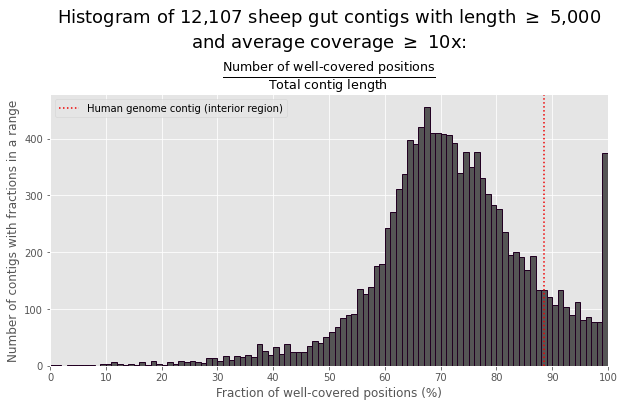

In [69]:
fracplot(
    e2wcfrac,
    r"Number\ of\ well" + u"\u2010" + r"covered\ positions",
    r"Total\ contig\ length",
    denclause=f"\nand average coverage $\geq$ {MIN_AVG_COV}x",
    xlabel="Fraction of well-covered positions (%)",
    figfilename="prokeuk_wcposfrac.png",
    bar_interior_color="#555555",
    vlines=[(human_wc_frac, "Human genome contig (interior region)")],
    use_symlog=0
)

## Histograms of mutation frequencies (one histogram per contig)

### Human contig

In [41]:
h_mut_rates_alt_gt_min = [mr[1] for mr in h_mut_rates if mr[0] >= MIN_ALT_FREQ]
pct = 100 * len(h_mut_rates_alt_gt_min) / len(h_mut_rates)
print(f"There are {len(h_mut_rates_alt_gt_min):,} / {len(h_mut_rates):,} ({pct:.2f}%) wc positions in the human contig interior with alt(pos) > 1.")

There are 145,050 / 87,940,234 (0.16%) wc positions in the human contig interior with alt(pos) > 1.


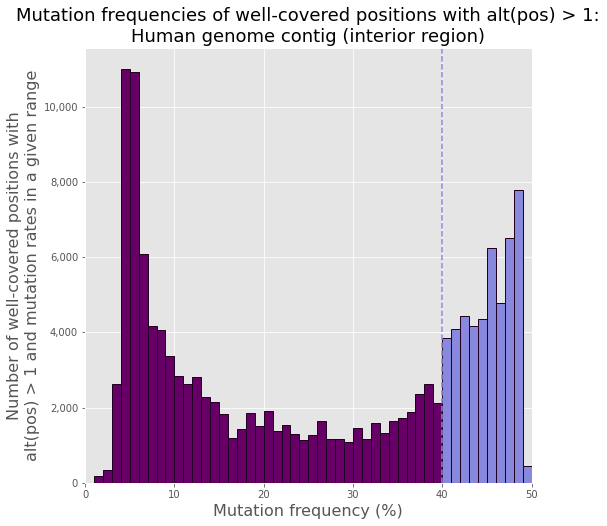

In [79]:
fig, ax = pyplot.subplots(1)

seq_mutrate_hist(ax, h_mut_rates_alt_gt_min, use_symlog=False)
ax.set_title(f"Mutation frequencies of well-covered positions with alt(pos) > 1:\nHuman genome contig (interior region)", fontsize=18)
ax.set_xlabel("Mutation frequency (%)", fontsize=16)
ax.set_ylabel(f"Number of well-covered positions with alt(pos) > 1\nand mutation frequencies in a given range", fontsize=16)

fig.set_size_inches(8, 8)
fig.savefig("figs/prokeuk_hcontig_mutrate_histogram.png", bbox_inches="tight")

### Sheep gut contigs

In [76]:
# Three selected bacterial MAGs used in the rare mutation report, plus two edges with low (or zero) fractions
probs_prok_seqs_to_check = ["edge_6104", "edge_1671", "edge_2358", "edge_8", "edge_5763"]
# Some edges with esp high fractions
probs_euk_seqs_to_check = ["edge_4371", "edge_26085", "edge_32274", "edge_38957", "edge_78779"]

In [85]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam")

seq2mincov_pos_mutation_rates = {}
for seq in (probs_euk_seqs_to_check + probs_prok_seqs_to_check):
    
    meancov = edge2meancov[seq]
    min_wc_cov = max(meancov - (meancov * COV_DEVIATION), 1)
    
    print(f"On seq {seq} (length {edge2len[seq]:,} bp, meancov = {meancov:,.2f}x, min wc cov = {min_wc_cov:,.2f}x).", end=" ")
    
    seq2mincov_pos_mutation_rates[seq] = []
    
    lenfrac = math.floor(edge2len[seq] / 50)
    
    # Same pileup iteration as above
    for ri, rec in enumerate(
        pysamstats.stat_variation(
            bf, chrom=seq, fafile="../main-workflow/output/all_edges.fasta", start=0, end=edge2len[seq],
            truncate=True, pad=True, max_depth=1e6
        ),
        1
    ):
        # very simple progress bar for my own sake. might miss a few dots here and there.
        # more granularity since fewer seqs
        if ri % lenfrac == 0:
            print("*", end="", flush=True)
            
        matches = rec["matches"]
        mismatches = rec["mismatches"]
        cov = matches + mismatches
        
        if cov >= min_wc_cov:
            _, f, rf = get_mutation_freq(rec)
            # enforce alt(pos) > 1
            if f >= MIN_ALT_FREQ:
                seq2mincov_pos_mutation_rates[seq].append(rf)
             
    assert ri == edge2len[seq]
    print("")
    
bf.close()

On seq edge_4371 (length 1,389,684 bp, meancov = 12.17x, min wc cov = 9.73x). **************************************************
On seq edge_26085 (length 852,638 bp, meancov = 136.91x, min wc cov = 109.53x). **************************************************
On seq edge_32274 (length 781,807 bp, meancov = 12.38x, min wc cov = 9.90x). **************************************************
On seq edge_38957 (length 1,227,999 bp, meancov = 45.63x, min wc cov = 36.50x). **************************************************
On seq edge_78779 (length 12,353 bp, meancov = 55.93x, min wc cov = 44.74x). **************************************************
On seq edge_6104 (length 1,289,244 bp, meancov = 4,158.96x, min wc cov = 3,327.17x). **************************************************
On seq edge_1671 (length 2,153,394 bp, meancov = 1,415.19x, min wc cov = 1,132.15x). **************************************************
On seq edge_2358 (length 2,806,161 bp, meancov = 2,993.88x, min wc cov = 2,395.10

#### Save this JSON data to a new file / Load it from that file so we can avoid redoing the above step if needed

(...because this data takes like 30 minutes to generate, and I don't want to have to melt an iceberg every time I want to change a color in one of these plots...)

In [86]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "w") as jf:
    jf.write(json.dumps(seq2mincov_pos_mutation_rates))

In [9]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "r") as jf:
    seq2mincov_pos_mutation_rates = json.load(jf)

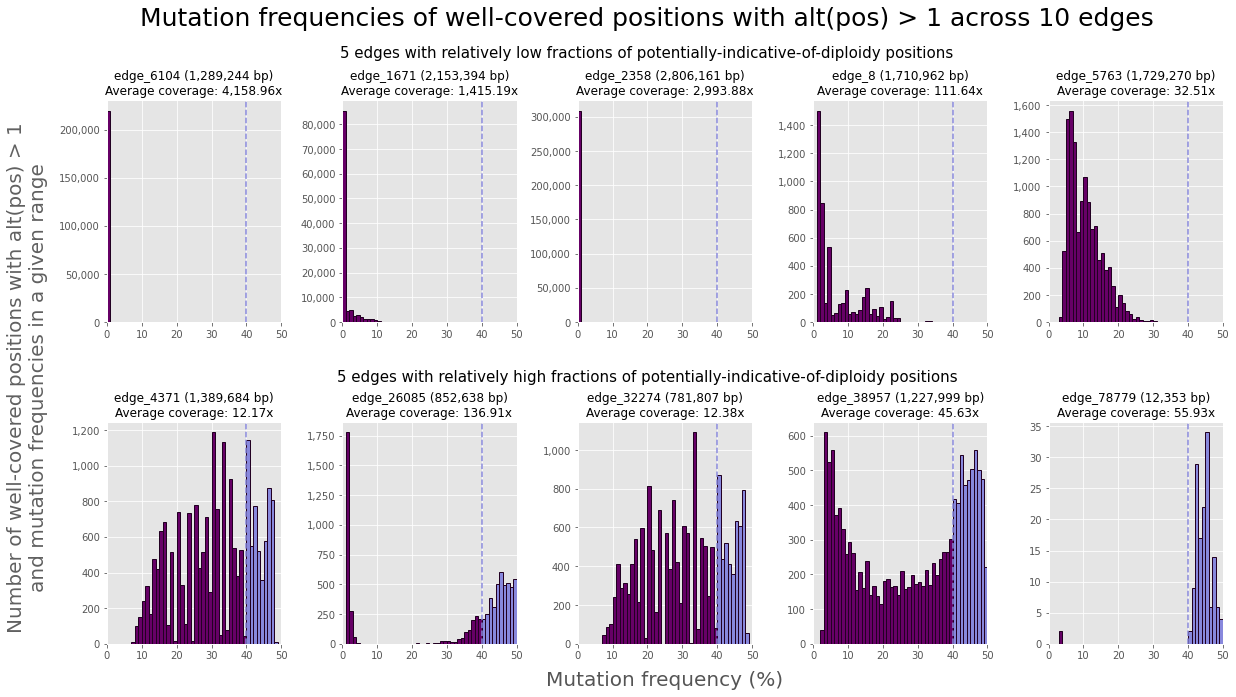

In [89]:
fig, axes = pyplot.subplots(2, 5, gridspec_kw={"wspace": 0.35, "hspace": 0.45})

rows = [probs_prok_seqs_to_check, probs_euk_seqs_to_check]
for ri, row in enumerate(rows):
    for ci, seq in enumerate(row):
        mut_rates = seq2mincov_pos_mutation_rates[seq]
        seq_mutrate_hist(axes[ri, ci], mut_rates, use_symlog=False)
        axes[ri, ci].set_title(f"{seq} ({edge2len[seq]:,} bp)\nAverage coverage: {edge2meancov[seq]:,.2f}x", fontsize=12)

axes[1, 2].set_xlabel("Mutation frequency (%)", fontsize=20, labelpad=10)
        
num_plotted_edges = sum([len(r) for r in rows])
# We move up the suptitle's y from 0.98 (default) as a very crude way to force the plot to have
# more space between this title and the row 1 title.
fig.suptitle(
    f"Mutation frequencies of well-covered positions with alt(pos) > 1 across {num_plotted_edges} edges",
    y=1.01,
    fontsize=25
)

# y-axis label: centered on the left side of the figure
fig.text(
    0.07, 0.495,
    f"Number of well-covered positions with alt(pos) > 1\nand mutation frequencies in a given range",
    color="#606060",
    fontsize=20,
    rotation=90,
    va="center",
    ha="center"
)
# Title for row 1. The y-value here is because this is figure coordinates, so this is "close to the top
# of the plot".
fig.text(
    0.5, 0.945,
    '5 edges with relatively low fractions of potentially-indicative-of-diploidy positions',
    fontsize=15,
    ha="center",
    va="center"
)
# Title for row 2.
fig.text(
    0.5, 0.495,
    '5 edges with relatively high fractions of potentially-indicative-of-diploidy positions',
    fontsize=15,
    ha="center",
    va="center"
)
fig.set_size_inches(20, 10)
fig.savefig("figs/prokeuk_10_mutrate_histograms.png", bbox_inches="tight")

## Visualize diploid fractions

In [91]:
# we already filtered h_mut_rates_alt_gt_min to positions with alt(pos) > 1 so we can just look at rel frequencies
human_diploid_ct = len([m for m in h_mut_rates_alt_gt_min if m >= MIN_DIPLOID_MAXALT_RELFREQ])
human_denominator_ct = len([m for m in h_mut_rates_alt_gt_min if m >= MIN_DENOMINATOR_MAXALT_RELFREQ])
hfrac = human_diploid_ct / human_denominator_ct
print(f"Human diploid fraction: {100 * hfrac:.2f}%")
print(f"Number of denominator positions: {human_denominator_ct:,}")

Human diploid fraction: 49.22%
Number of denominator positions: 102,274


In [95]:
def dfplot(min_denominator_val, use_symlog=True, figfilename=None):
    
    if min_denominator_val < 0:
        raise ValueError("Min denominator val has to be at least 0, otherwise we get division by 0 errors...")
    
    e2frac = {}
    for e in edge2num_wc_den_pos:
        if edge2num_wc_den_pos[e] > min_denominator_val:
            e2frac[e] = edge2num_wc_diploid_pos[e] / edge2num_wc_den_pos[e]
    
    prefix = r"Number\ of\ well" + u"\u2010" + r"covered\ positions\ with\ mutation\ rates\ \geq "

    fracplot(
        e2frac,
        # We explicilty use the unicode character for the hyphen to prevent LaTeX from treating it as a
        # minus symbol. This is a bit harder to handle simply in matplotlib-using-LaTeX than it is in just
        # vanilla LaTeX. Idea to use unicode chars c/o https://stackoverflow.com/a/30201951 (although I used
        # a different unicode character).
        prefix + "40\%\ and\ alt(pos)\ > 1",
        prefix + "10\%\ and\ alt(pos)\ > 1",
        denclause=f",\naverage coverage $\geq$ 10x, and a denominator $\geq$ {min_denominator_val:,}",
        figfilename=figfilename,
        use_symlog=use_symlog,
        vlines=[(hfrac, "Human genome contig (interior region)")]
    )

### All contigs with a nonzero denominator

8,970 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78793); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_77463', 'edge_77680', 'edge_77713', 'edge_78010', 'edge_78042', 'edge_78090', 'edge_78642', 'edge_78779', 'edge_78789', 'edge_78793']
Bottom 10 edges: ['edge_8', 'edge_17', 'edge_37', 'edge_46', 'edge_66', 'edge_67', 'edge_72', 'edge_106', 'edge_120', 'edge_322']
8,235 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_75791', 'edge_75991', 'edge_76606', 'edge_76641', 'edge_77059', 'edge_77147', 'edge_78042', 'edge_78090', 'edge_78642', 'edge_78779']
Bottom 10 edges: ['edge_8', 'edge_17', 'edge_37', 'edge_67', 'edge_72', 'edge_106', 'edge_120', 'edge_430', 'edge_490', 'edge_504']
8,077 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 0.0 (edge edge_8)
Top 10 edges: ['edge_74984', 'edge_75735', 'edge_75791', 'edge_75991', 'edge_76641', 'edg

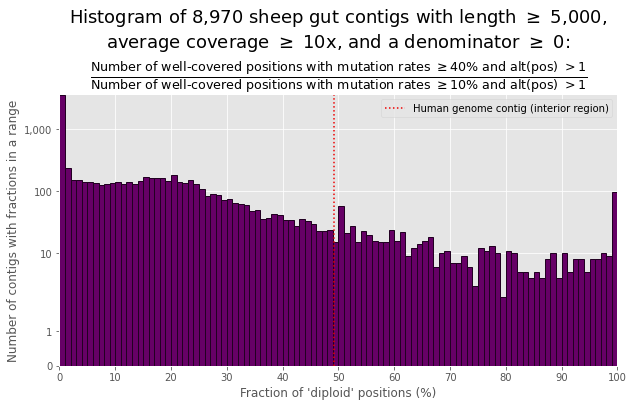

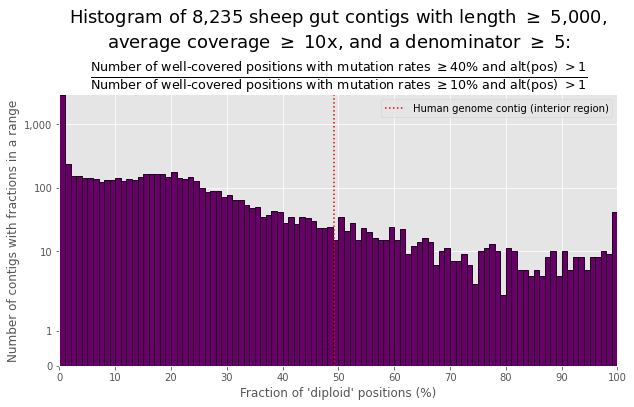

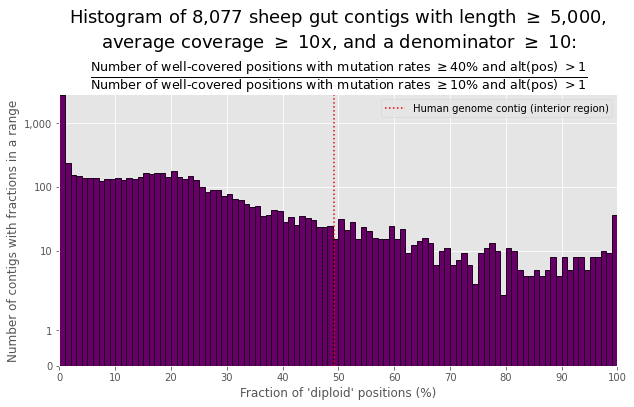

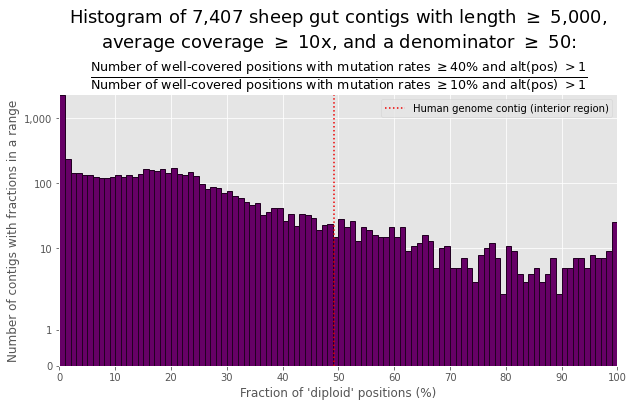

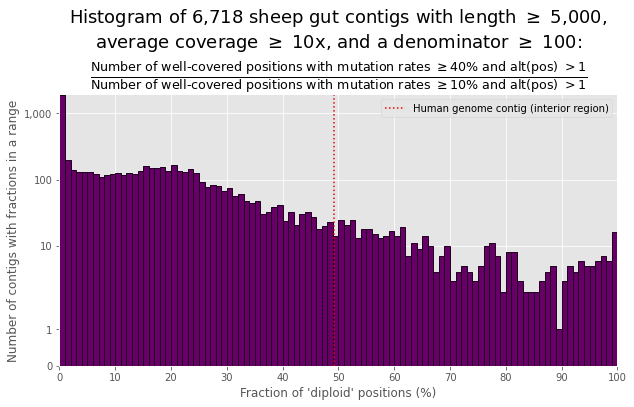

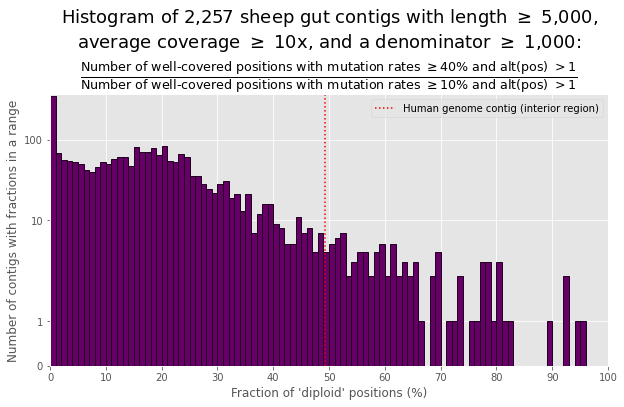

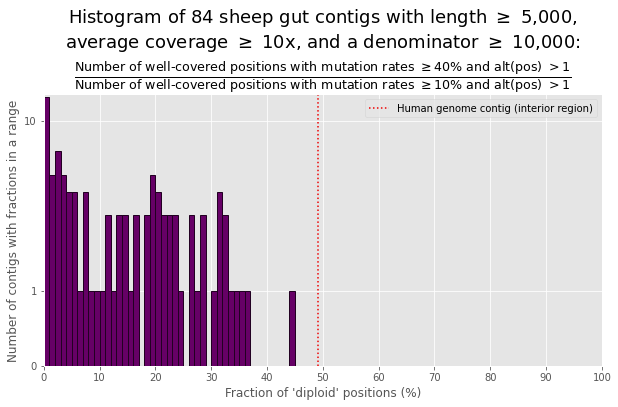

In [96]:
for minden in (0, 5, 10, 50, 100, 1000, 10000):
    dfplot(minden, use_symlog=True, figfilename=f"prokeukfrac_minden{minden}.png")

In [66]:
def estats(e):
    num_dip = edge2num_wc_diploid_pos[e]
    num_den = edge2num_wc_den_pos[e]
    num_mcp = edge2num_wc_pos[e]
    print(f"{e} ({edge2len[e]:,} bp long, {edge2meancov[e]:,.2f}x avg cov) has", end=" ")
    print(f"{num_mcp:,} WC pos.", end=" ")
    print(f"{num_dip:,} WC 'diploid' pos.", end=" ")
    print(f"{num_den:,} WC 'denominator' pos.")
    #if e in e2frac:
    #    print(f"\tDiploid fraction: {e2frac[e] * 100:.2f}%")
    #else:
    #    print("\tDiploid fraction undefined for this edge.")

In [74]:
estats("edge_78793")
estats("edge_5763")
estats("edge_78779")
estats("edge_26085")
estats("edge_38957")
estats("edge_32274")
estats("edge_4371")

edge_78793 (39,434 bp long, 29.65x avg cov) has 34,412 WC pos. 2 WC 'diploid' pos. 2 WC 'denominator' pos.
edge_5763 (1,729,270 bp long, 32.51x avg cov) has 1,436,967 WC pos. 0 WC 'diploid' pos. 6,084 WC 'denominator' pos.
edge_78779 (12,353 bp long, 55.93x avg cov) has 12,334 WC pos. 148 WC 'diploid' pos. 148 WC 'denominator' pos.
edge_26085 (852,638 bp long, 136.91x avg cov) has 711,925 WC pos. 4,426 WC 'diploid' pos. 5,496 WC 'denominator' pos.
edge_38957 (1,227,999 bp long, 45.63x avg cov) has 942,208 WC pos. 4,759 WC 'diploid' pos. 10,613 WC 'denominator' pos.
edge_32274 (781,807 bp long, 12.38x avg cov) has 512,885 WC pos. 5,553 WC 'diploid' pos. 17,578 WC 'denominator' pos.
edge_4371 (1,389,684 bp long, 12.17x avg cov) has 908,029 WC pos. 6,766 WC 'diploid' pos. 20,620 WC 'denominator' pos.
